# Análisis Topológico de los Datos

En este cuadernillo haremos la comparación de las tarifas totales de reservaciones en los servicios de hotelería ofrecidos durante Febrero 2019 hasta Enero 2020, para determinar si existía una periodicidad respecto a los ingresos que lograría generar.

In [23]:
import pandas as pd
import numpy as np

## Limpieza y Transformación de datos

In [ ]:
iar_Reservaciones = pd.read_csv('/Users/fernandalee/Downloads/Reto/Data/Tablas/iar_Reservaciones.csv')
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["aa_h_num_per"] == 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] >= 0]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones["h_tfa_total"] <= 200000]
iar_Reservaciones = iar_Reservaciones[[col for col in iar_Reservaciones.columns if not col.startswith("aa")]]
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] >= '2019-01-01']
iar_Reservaciones = iar_Reservaciones[iar_Reservaciones['h_fec_lld_okt'] <= '2020-01-01']
iar_Reservaciones = iar_Reservaciones.sort_values('h_fec_lld_okt')
iar_Reservaciones = iar_Reservaciones.set_index('h_fec_lld_okt')
iar_Reservaciones.index = pd.to_datetime(iar_Reservaciones.index, errors='coerce')

/var/folders/8n/8bjdlpfd1fxggmklmx0rdw8w0000gn/T/ipykernel_85943/1630505069.py:1: DtypeWarning:

Columns (22,28) have mixed types. Specify dtype option on import or set low_memory=False.



## Obtención de Datos

Hacemos un nuevo registro de datos, donde se calcula la media de tarifas por cada día.

In [ ]:
data = (
    iar_Reservaciones
    .groupby('h_fec_lld_okt')['h_tfa_total']
    .mean()
    .reset_index()
)

data.columns = ['Fecha', 'tarifa']
data

,Fecha,tarifa
0,2019-02-05,672.800000
1,2019-02-06,11052.000000
2,2019-02-12,18999.200000
3,2019-02-13,4702.505750
4,2019-02-14,4788.576467
...,...,...
320,2019-12-27,15034.176049
321,2019-12-28,12911.803546
322,2019-12-29,15648.286371
323,2019-12-30,16218.035503


## Serie de Tiempo 

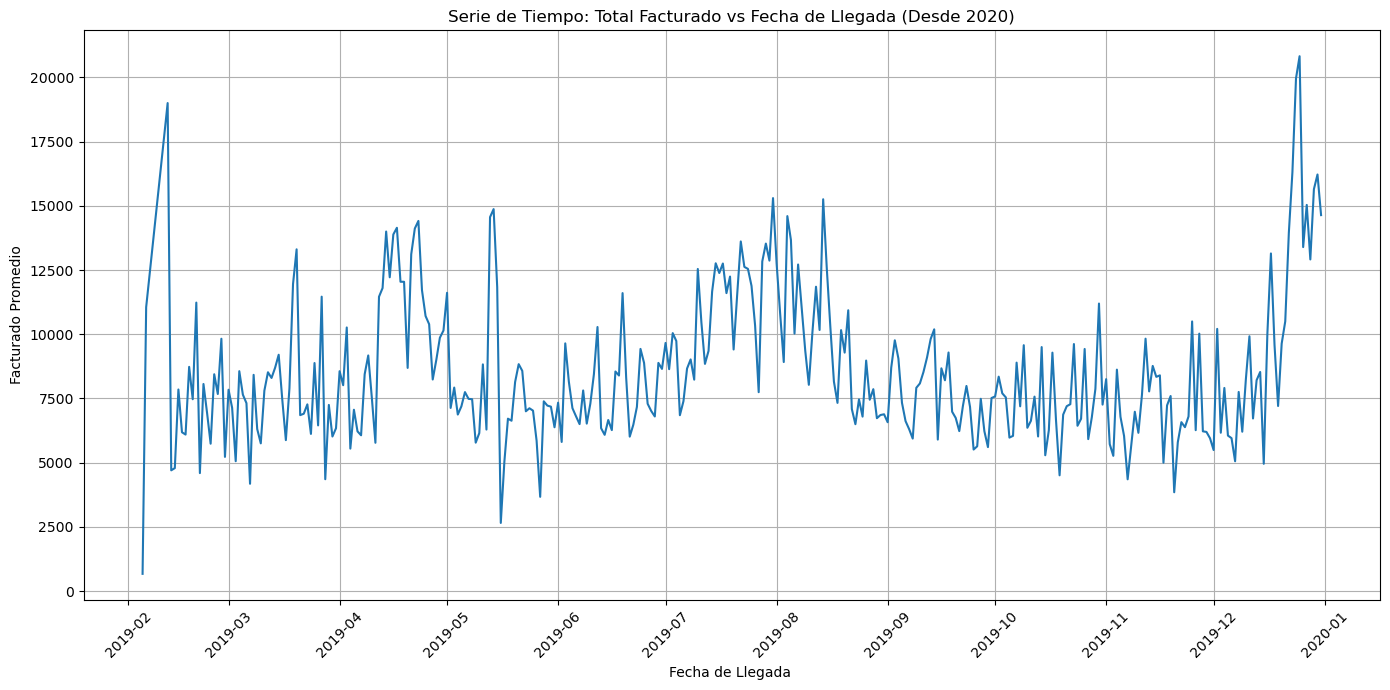

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
sns.lineplot(
    data=data,
    x='Fecha',
    y='tarifa'
)
plt.title('Serie de Tiempo: Total Facturado vs Fecha de Llegada (Desde 2020)')
plt.xlabel('Fecha de Llegada ')
plt.ylabel('Facturado Promedio')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Descomposición de Serie de Tiempo

Esto nos permitirá entender la composición y características de la línea temporal con respecto a la variable de tarifa.

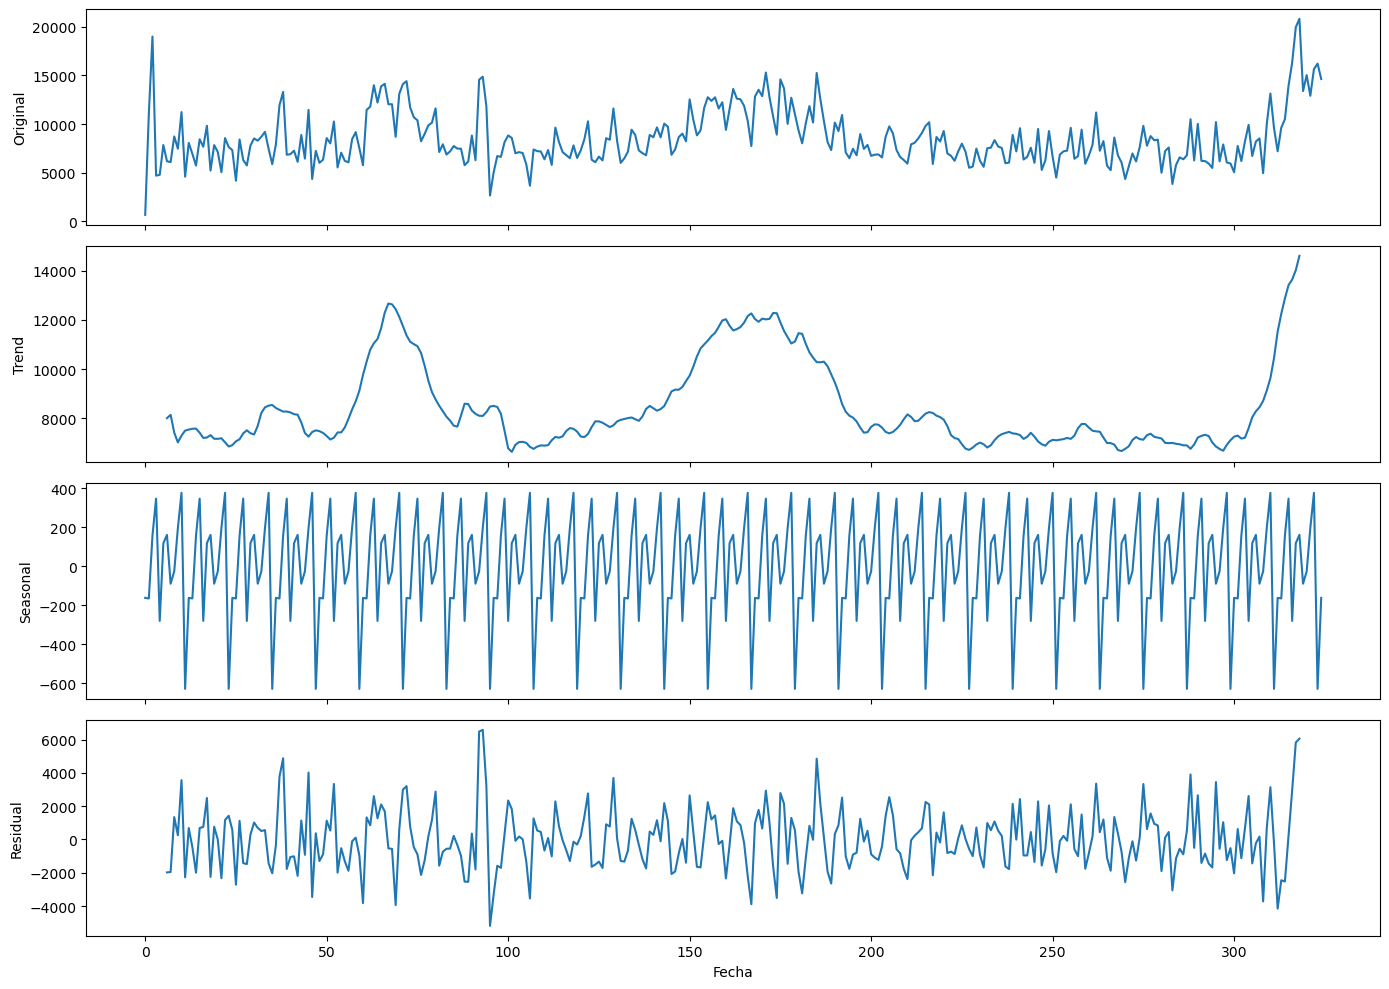

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(data["tarifa"], model='additive', period=12)  
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Serie original
ax1.plot(result.observed)
ax1.set_ylabel('Original')

# Tendencia
ax2.plot(result.trend)
ax2.set_ylabel('Trend')

# Estacionalidad
ax3.plot(result.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(result.resid)
ax4.set_ylabel('Residual')

plt.xlabel('Fecha')
plt.tight_layout()
plt.show()

Tendencia:
Hay leves subidas en fechas estratégicas como en temporadas de semana santa, a mediados del año (verano) y a final del año.

Estacionalidad:
Se ve un patrón repetitivo bastante claro. Esto indica que la serie tiene ciclos diarios.

Residuos:
Se ven algunos saltos grandes, pero en general el residuo se mantiene relativamente estable.

## Realización del análisis topológico

Ya que vimos estas características, comprobemos como quedaría este análisis si escalamos los datos de tarifa promedio a otras dimensiones para ver la periodicidad de las tarifas con respecto a la temporada.

Aquí aplicamos la normalización de los datos de tarifa, para después aplicarla para el encaje de takens; técnica utilizada para reconstruir la dinámica de un sistema dinámico complejo, que sirve sobretodo para observar su periodicidad y entender su evolución temporal. 

In [40]:
from sklearn.preprocessing import StandardScaler
signal = data["tarifa"]
scaler = StandardScaler()
signal = scaler.fit_transform(signal.values.reshape(-1, 1)).flatten()

delay = 1
dimension = 3 

def takensEmbedding(data, delay, dimension):
    if (delay * (dimension - 1)) >= len(data):
        raise ValueError('Delay * (dimension-1) debe ser menor que el tamaño de los datos.')
    
    embedded_data = np.column_stack([data[i*delay: len(data) - (delay * (dimension - i - 1))] for i in range(dimension)])
    return embedded_data

embedded_signal = takensEmbedding(signal, delay, dimension)



## Visualización del Encaje de Takens en 2-D

In [35]:
import plotly.express as px
import pandas as pd

df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])

fig = px.scatter(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    title='Encaje de Takens (2D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=500)
fig.show()

Podemos observar que existe cierta tendencia en cuanto al incremento de las tarifas, por lo que si hay un incremento de ingreso, se tiende a seguir incrementando. Visualmente podemos ver una correlación positiva entre su valor con el desfase (1).

## Visualización del Encaje de Takens en 3-D

In [ ]:
df_embedded = pd.DataFrame(embedded_signal, columns=[f'Dim_{i+1}' for i in range(embedded_signal.shape[1])])
fig = px.scatter_3d(
    df_embedded,
    x='Dim_1',
    y='Dim_2',
    z='Dim_3',
    title='Encaje de Takens (3D)',
    labels={'Dim_1': 'Primera dimensión', 'Dim_2': 'Segunda dimensión', 'Dim_3': 'Tercera dimensión'},
    opacity=0.7
)
fig.update_layout(width=700, height=600)
fig.show()

Podemos observar aquí una dispersión un poco mayor, la nube de puntos no es uniforme puesto a que tiene zonas de mayor densidad y otras más dispersas, lo que refleja periodos de estabilidad combinados con cambios abruptos en la serie. Esta representación en tercera dimensiónn capta mejor estos cambios que podrían pasar desapercibidos en la segunda dimensión.

## Diagrama de Persistencia

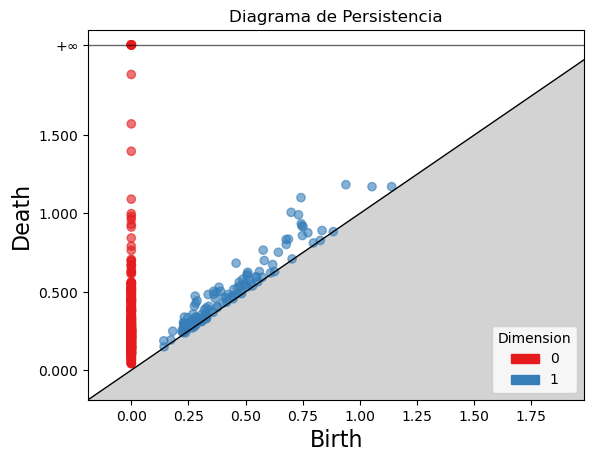

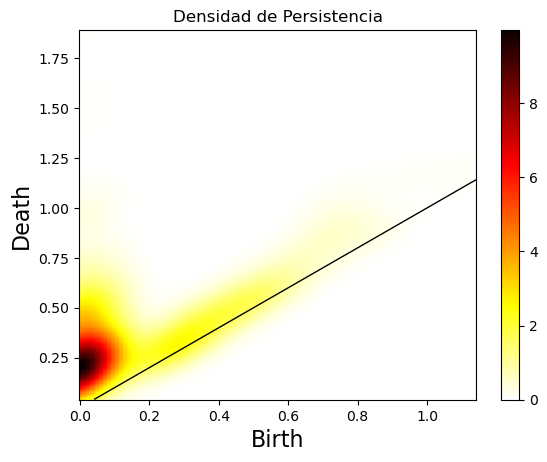

In [37]:
import gudhi as gd
import matplotlib.pyplot as plt

rips_complex = gd.RipsComplex(points=embedded_signal, max_edge_length=2.0)

simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

diag = simplex_tree.persistence()

gd.plot_persistence_diagram(diag)
plt.title('Diagrama de Persistencia')
plt.show()

gd.plot_persistence_density(diag)
plt.title('Densidad de Persistencia')
plt.show()



En el diagrama de persistencia, podemos observar lo siguiente.

- Betti 0: inicialmente hay muchas componentes desconectadas que rápidamente se van uniendo en una sola gran componente a medida que aumentas la escala. El hecho de que algunos lleguen hasta infinito sugiere que una componente principal permanece conectada todo el tiempo.

- Betti 1: Si hay pequeños ciclos en la forma de los datos, pero no son estructuras muy persistentes ni dominantes.

Adicionalmente, tenemos un diagrama de densidad que nos muestra de forma similar el comportamiento de los datos de tarifa, que al pricipio estos se van acumulando y tal como se pudo ver, existe una componente conexa. Pero estos datos no son lo suficientemente persistentes para predecir las tarifas puesto a que sus características de periodicidad no son lo suficientemente estables.  